## WEEK 5

#### 1.
Для каждой из шести задач прогнозирования yT+i|T, i=1,…,6 сформируйте выборки. Откликом будет yT+i при всевозможных значениях T

In [1]:
import utils
import gc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from types import SimpleNamespace
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin
from scipy.sparse import csr_matrix

In [2]:
%%time
# Выгрузим данные по зонам из числа отобранных на второй неделе, то есть те, у которых в мае 2016 года было больше 5 поездок в час
# Выгрузим данные за два года, т.к. на этой неделе не надо считать ариму
aws = utils.AWSUtils()
data = aws.pd_read_sql(
    sql="\
    SELECT \
        dt.trip_datetime, \
        r.region_id, \
        COALESCE(ad.trip_count_sum, 0) trip_count_sum \
    FROM \
        mldb.taxi_tripdt dt \
        CROSS JOIN taxi_regions r \
        LEFT JOIN mldb.taxi_aggregateddata ad ON ad.pickup_datetime=dt.trip_datetime and ad.pickup_region_id=r.region_id \
        INNER JOIN \
            (SELECT \
                pickup_region_id, \
                sum(trip_count_sum)/24/31 trip_avg_ph \
            FROM \
                 mldb.taxi_aggregateddata \
            WHERE \
                MONTH(pickup_datetime) = 5 \
                AND YEAR(pickup_datetime) = 2016 \
            GROUP BY \
                pickup_region_id \
            HAVING \
                trip_avg_ph >= 5 \
            ) adf ON adf.pickup_region_id = r.region_id \
    WHERE \
        dt.trip_datetime BETWEEN '{min_dt}' AND '{max_dt}';"
    .format(
        min_dt='2014-05-01 00:00:00',
        max_dt='2016-06-30 23:00:00'
    ),
    index_col='trip_datetime',
    parse_dates={'trip_datetime': {'format': '%Y-%m-%d %H:%M:%S'}}
)

CPU times: user 31.5 s, sys: 1.3 s, total: 32.8 s
Wall time: 1min 25s


In [3]:
# должны получиться данные по 102 регионам, проверим это
data.region_id.unique().shape

(102,)

In [4]:
# посмотрим на данные, что все выгрузилось корректно
data.tail()

,region_id,trip_count_sum
trip_datetime,,
2016-06-30 23:00:00,1390,15
2016-06-30 23:00:00,1439,9
2016-06-30 23:00:00,1441,2
2016-06-30 23:00:00,1442,5
2016-06-30 23:00:00,1783,110


In [5]:
class TripData():
    def __init__(self, data):
        self.date_index = data.index.unique()
        self.data = data
        self._fit_X_y()
    
    def _fit_X_y(self):
        
        self.train_idx = np.where(self.data.index.isin(self.data.loc[:'2016-04-30 17:00:00'].index))[0]
        self.test_idx = np.where(self.data.index.isin(self.data.loc['2016-04-30 23:00:00':'2016-05-31 17:00:00'].index))[0]
        self.final_idx = np.where(self.data.index.isin(self.data.loc['2016-05-31 23:00:00':'2016-06-30 17:00:00'].index))[0]

        self._X = TaxiTripTransformer(self.date_index).fit_transform(self.data)
        self._X_train = self._X[np.where(self.data.index.isin(self.data.loc[:'2016-05-31 17:00:00'].index))[0]]
        self._X_test = self._X[self.final_idx]
         
        self._y = {
            T: self._shift_y(self.data, T) for T in range(1, 6+1)
        }
        
        self._y_train = {
            T: self._shift_y(
                self.data.loc[:'2016-05-31 23:00:00'], T
            ).iloc[: self._X_train.shape[0]] for T in range(1, 6+1)
        }
        
        self._y_test = {
            T: self._shift_y(
                self.data.loc['2016-06-01 00:00:00':'2016-06-30 23:00:00'], T
            ).iloc[: self._X_test.shape[0]] for T in range(1, 6+1)
        }
    
    def _shift_y(self, data, T):
        region_count = data.region_id.unique().shape[0]
        return data.shift(-T*region_count).fillna(0).trip_count_sum
    
    def train(self, T):
        return SimpleNamespace(
            X=self._X_train,
            y=self._y_train[T]
        )
    
    def test(self, T):
        return SimpleNamespace(
            X=self._X_test,
            y=self._y_test[T]
        )
    
    def cv(self):
        yield (
            self.train_idx,
            self.test_idx
        )

# генератор новых признаков
class TaxiTripTransformer(TransformerMixin):
    def __init__(self, series_index):
        self.series_index = series_index

    def _fourier_harmonic(self, X, series_index, k_values, period):
        values = np.array([series_index.get_loc(n) for n in X.index.values])
        
        return csr_matrix(
            np.array([
                func(values*2*math.pi*k/period) for k in k_values for func in (np.sin, np.cos)
            ]).T
        )
    
    def _shift_defauls(self, X):
        df = X.copy()
        df.loc[:, 'hour'] = df.index.hour
        
        return (
            df.pivot_table(
                values='trip_count_sum', 
                index='hour',
                columns='region_id',
                fill_value=0
            )
            .groupby(['hour'])
            .mean()
        )
    
    def _shift_function(self, X, range_func):
        df_defauls = self._shift_defauls(X)
        
        X_pivot = X.pivot_table(
            values='trip_count_sum', 
            index='trip_datetime', 
            columns='region_id',
            fill_value=0
        )

        return csr_matrix(
            np.array([
                X_pivot
                .shift(hour)
                .fillna(
                    X_pivot
                    .head(hour)
                    .apply(
                        lambda x: df_defauls.loc[(x.name-pd.Timedelta(hours=hour)).hour], 
                        axis=1
                    )
                )
                .stack()
                for hour in range_func
            ]).T
        )

    def _sum_function(self, X, periods):
        X_pivot = X.pivot_table(
            values='trip_count_sum', 
            index='trip_datetime', 
            columns='region_id',
            fill_value=0
        )

        return csr_matrix(
            np.array([
                X_pivot
                .rolling(window = period)
                .sum()
                .shift()
                .fillna(X_pivot.mean())
                .stack()
                for period in periods
            ]).T
        )
    
    def _feature_union(self):
        return FeatureUnion(
            n_jobs = -1,
            transformer_list = [

                # недельные гармоники
                ('week_harmonic_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._fourier_harmonic(
                                X=data, 
                                series_index=self.series_index, 
                                k_values=[2,3,4,5,7,9,12,14,17,19,21,24,28,31], 
                                period=24*7
                            )
                        )),
                    ]
                )),

                # годовые гармоники
                ('year_harmonic_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._fourier_harmonic(
                                X=data, 
                                series_index=self.series_index, 
                                k_values=[2,3,4,6,8,12,16,24,32,48,64,121,182,244,365],
                                period=24*365.25
                            )
                        )),
                    ]
                )),

                # идентификатор географической зоны
               ('region_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.region_id), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),
                
                # год
                ('year_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.index.year), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),

                # номер месяца
                ('month_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.index.month), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),

                # день недели
                ('dayofweek_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.index.dayofweek), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),                        

                # часы
                ('hour_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.index.hour), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),

                # количество поездок 1..24 часов назад
                ('trip_hour_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._shift_function(
                                X=data,
                                range_func=range(1, 24+1, 1)
                            )
                        )),
                        ('scaling', StandardScaler(with_mean=False))
                    ]
                )),

                # количество поездок 24..168 часов назад
                ('trip_day_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._shift_function(
                                X=data,
                                range_func=range(24, 24*7+1, 24)
                            )
                        )),
                        ('scaling', StandardScaler(with_mean=False))
                    ]
                )),

                # суммарное количество поездок за полдня, день, неделю, месяц
                ('trip_sum_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._sum_function(
                                X=data,
                                periods=[12, 24, 24*7, 24*30]
                            )
                        )),
                        ('scaling', StandardScaler(with_mean=False))
                    ]
                )),
            ]
        )
    
    
    def fit_transform(self, X):
        return self._feature_union().fit_transform(X)

#### 2. 
Разбейте каждую из шести выборок на три части:

    обучающая, на которой будут настраиваться параметры моделей — всё до апреля 2016
    тестовая, на которой вы будете подбирать значения гиперпараметров — май 2016
    итоговая, которая не будет использоваться при настройке моделей вообще — июнь 2016

In [6]:
%%time
# разбиение будет в классе TripData
trip_data = TripData(data)

Wall time: 38.3 s


#### 3. 
Выберите вашу любимую регрессионную модель и настройте её на каждом из шести наборов данных, подбирая гиперпараметры на мае 2016.
Желательно, чтобы модель:

    допускала попарные взаимодействия между признаками
    была устойчивой к избыточному количеству признаков (например, использовала регуляризаторы)
    
Так как у нас будет, фактически, 102 независимых ряда, надо выбрать модель, которая позволяет строить n различных моделей. Самое подходящее для этой задачи решение мне видится в использовании решающих деревье. Наиболее мощный инструмент для построения регрессионной модели на основе деревьев решений - XGBoost. Мною были протестированы различные алгоритмы, однако наилучших результатов удалось добиться именно на XGBoost.

In [7]:
def search_regressor(trip_data, T):
    regressor = XGBRegressor(n_estimators=7*102, n_jobs=-1, tree_method='gpu_hist')
    
    train_data = trip_data.train(T)
    X, y = train_data.X, train_data.y

    parameters_grid = {
        'estimator__model_fitting__max_depth' : np.linspace(3, 9, num = 3, dtype=np.int),
        'estimator__model_fitting__min_child_weight' : np.linspace(1, 5, num = 3, dtype=np.int),
        'estimator__model_fitting__gamma' : [0, 0.1, 0.3, 0.5],
        'estimator__model_fitting__subsample': [0.5, 0.6, 0.8, 1.],
        'estimator__model_fitting__colsample_bytree': [0.5, 0.6, 0.8, 1.],
        'estimator__model_fitting__alpha' : [0, 0.05, 0.1, 0.5, 1., 3., 5.],
        'estimator__model_fitting__lambda' : [0, 0.05, 0.1, 0.5, 1., 3., 5.],
    }

    randomized_grid_cv = RandomizedSearchCV(
        regressor,
        parameters_grid,
        scoring = 'neg_mean_squared_error',
        cv = trip_data.cv(),
        n_iter=72,
        verbose=2,
        n_jobs=1
    ).fit(X, y)

    print(randomized_grid_cv.best_score_)
    print(randomized_grid_cv.best_params_)

    return randomized_grid_cv.best_estimator_

In [8]:
%%time
# подберем оптимальные параметры на 6-ти часовой выборке, чтобы использовать их для остальных выборок
# кросс-валидация по выборке мая 2016
best_estimator = search_regressor(trip_data, 6)

Fitting 1 folds for each of 72 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 367.7min finished


-2760.3699929804106
{'estimator__model_fitting__subsample': 1.0, 'estimator__model_fitting__min_child_weight': 1, 'estimator__model_fitting__max_depth': 9, 'estimator__model_fitting__lambda': 3.0, 'estimator__model_fitting__gamma': 0.3, 'estimator__model_fitting__colsample_bytree': 1.0, 'estimator__model_fitting__alpha': 0.05}
Wall time: 6h 15min 17s


In [9]:
%%time
# посмотрим результат на мае 2016, по которому проводилась кросс-валидация
test_idx = trip_data.test_idx
X_test = trip_data.train(6).X[test_idx]
y_test = trip_data.train(6).y[test_idx]

y_pred = best_estimator.predict(X_test)
y_err = abs(y_test - y_pred)
print(
    'Средняя абсолютная ошибка в мае 2016 на шестичасовом прогнозе: {}'
    .format(y_err.mean())
)

Средняя абсолютная ошибка в мае 2016 на шестичасовом прогнозе: 19.417149387581198
Wall time: 7.43 s


Средняя абсолютная ошибка на майской выборке - 19.42. Это лучше, чем на было 4 неделе при обучении на ARIMA (ошибка тогда составила 32.08). 

Посмотрим на график ошибки и сравним с ошибками модели ARIMA из 4-й недели

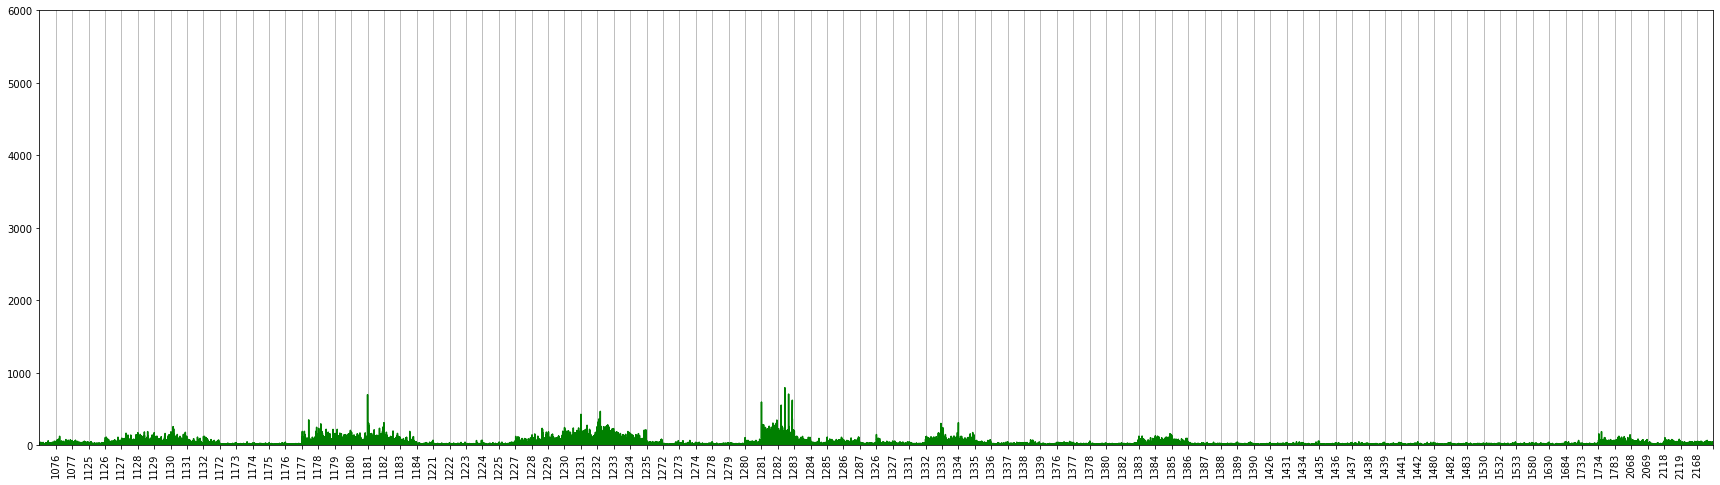

In [10]:
# график ошибок по зонам, модель XGBoost
data_test = trip_data.data.iloc[test_idx]
data_test.loc[:, 'err'] = y_err
fig, ax = plt.subplots(figsize=(30,8))
ax.set_xlim(1, data_test.shape[0])
ax.set_ylim(0, 6000)
ax.set_xticklabels(np.sort(data_test.region_id.unique()))
ax.xaxis.set_major_locator(ticker.MultipleLocator(744))
ax.xaxis.grid(True, which='major')
ax.xaxis.set_tick_params(rotation=90)
ax.plot(
    data_test
    .reset_index()
    .set_index(['region_id', 'trip_datetime'])
    .sort_index()
    .err
    .values,
    color='green'
)

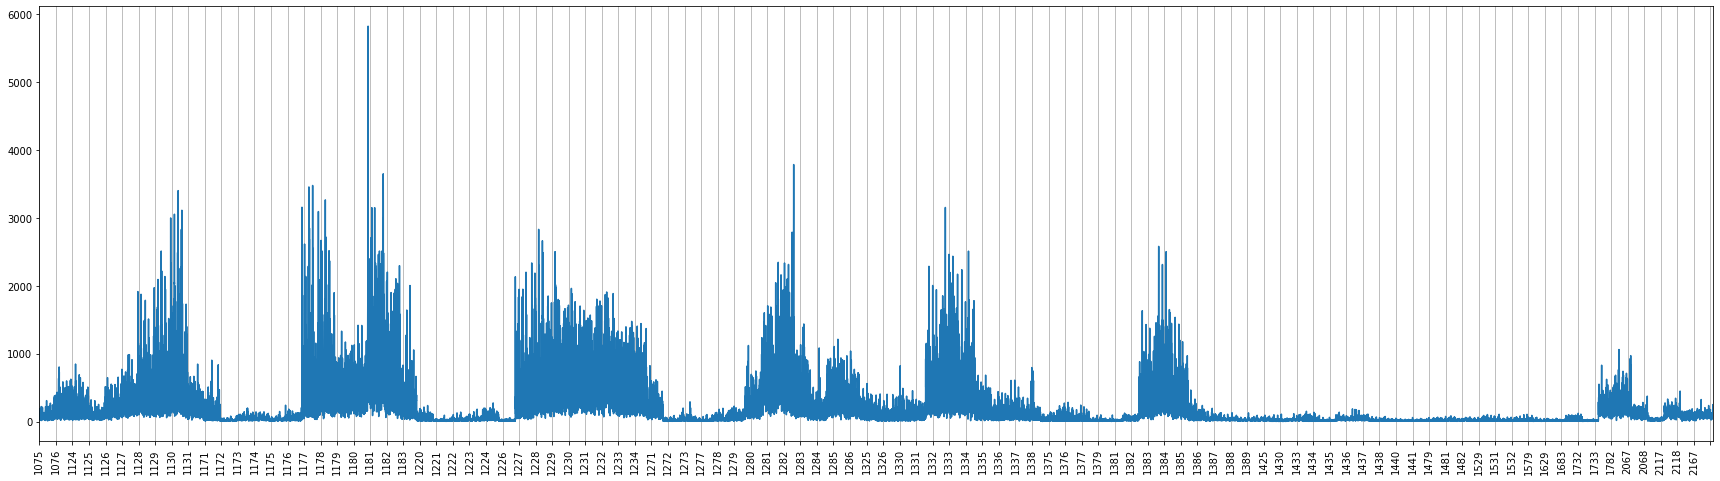

In [11]:
# график ошибок по зонам, модель ARIMA

По графику ошибок видно, что:

    1) в среднем, максимальные абсолютные ошибки на XGBoost меньше, чем на модели ARIMA. Это обусловлено тем, что на XGBoost использовалось больше признаков, а также, тем, что в обучении участвовали все зоны (в случае модели ARIMA обучение проводилось по зонам, являющихся центрами кластеров)
    
    2) отклонения от прогноза выше среднего возникают на одних и тех же зонах, необходим более детальный анализ их для объяснения этих аномалий. Это будем делать на 6-й неделе.

#### 4.
Выбранными моделями постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд.
Убедитесь, что ошибка полученных прогнозов, рассчитанная согласно функционалу Q, определённому на прошлой неделе, уменьшилась по сравнению с той, которую вы получили методом индивидуального применения моделей ARIMA. Если этого не произошло, попробуйте улучшить ваши модели.

In [12]:
def calc_predictions(trip_data, **params):
    
    train_idx = trip_data.train_idx
    test_idx = trip_data.test_idx
    final_idx = trip_data.final_idx
    
    # dataframe для ошибок в мае 2016
    errors = trip_data.data.iloc[test_idx].loc[:, ['region_id']]
    
    # dafarame для прогноза в июне 2016
    predictions = trip_data.data.iloc[final_idx].loc[:, ['region_id']]
    
    for T in range(1, 6+1):
        print('build model for T={}'.format(T))

        train_data = trip_data.train(T)
        test_data = trip_data.test(T)
        
        X_train = train_data.X[train_idx]
        y_train = train_data.y[train_idx]
        X_may = train_data.X[test_idx]
        y_may = train_data.y[test_idx]
        X_june = test_data.X

        model = XGBRegressor(
            n_jobs=-1, 
            tree_method='gpu_hist',
            **params
        ).fit(X_train, y_train)

        y_pred_may = model.predict(X_may)
        y_pred_june = model.predict(X_june)
        
        errors.loc[:, '{}'.format(T)] = (abs(y_pred_may - y_may))
        predictions.loc[:, '{}'.format(T)] = y_pred_june
        
        del model
        gc.collect()
    
    return predictions, errors

In [13]:
%%time
predictions, errors = calc_predictions(
    trip_data,
    n_estimators=7*102,
    eta=0.1,
    max_depth=9,
    reg_alpha=0.05,
    reg_lambda=3.0,
    gamma=0.3
)

build model for T=1
build model for T=2
build model for T=3
build model for T=4
build model for T=5
build model for T=6
Wall time: 44min 27s


In [30]:
# проверим размер получившихся массивов.
# для мая 2016 должен быть размер 102*739*6 = 75378*6
print('Май 2016: {}'.format(errors.shape))

# для июня 2016 должен быть размер 102*715*6 = 72930*6
print('Июнь 2016: {}'.format(predictions.shape))

Май 2016: (75378, 7)
Июнь 2016: (72930, 7)


In [31]:
# ошибка прогноза на мае 2016:
print(
    'Средняя абсолютная ошибка прогноза в мае 2016: {}'
    .format(errors.iloc[:, 1:].mean().mean())
)

Средняя абсолютная ошибка прогноза в мае 2016: 21.676409275723078


Ошибка уменьшилась по сравнению с полученной при применении модели ARIMA (32.078336249808935).
Сейчас при обучении не использовалась кросс-валидация на этой выборке, потому ошибка немного выше по сравнению с той, которую мы получили при подборе гиперпараметров (19.42)

#### 5. 
Итоговыми моделями постройте прогнозы для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в формате geoID, histEndDay, histEndHour, step, y. Здесь geoID — идентификатор зоны, histEndDay — день конца истории в формате yyyy.mm.dd, histEndHour — час конца истории от 0 до 23, step ∈{1,2,3,4,5,6} — номер отсчёта, на который вы делаете предсказание, y — предсказываемое значение.

In [63]:
# функция формирования прогноза в заданном формате и записи в файл
def write_predictions(df):
    predictions = df.apply(
        lambda row: ''.join([
            '{region}_{:%Y-%m-%d}_{hour}_{ref},{pred}\n'.format(
                row.name,
                hour=row.name.hour,
                region=int(row.region_id),
                ref=T,
                pred=max(row[T], 0)
            ) for T in range(1, 6+1)
        ]),
        axis=1,
    )
    
    with open('june_predict_5.csv', "w") as csv:
        csv.write('id,y\n')
        csv.write(''.join(predictions))

In [64]:
%%time
write_predictions(predictions)

Wall time: 17 s


#### 6. 
Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

Ссылка: https://www.kaggle.com/submissions/15330390/15330390.raw

Score: 26.85705

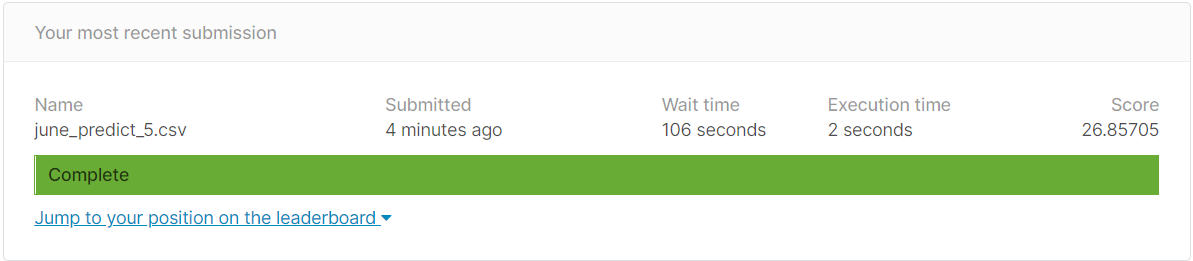

In [65]:
from IPython.display import Image
Image(filename='image.png') 